In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

#PART 1: EXPLORATORY DATA ANALYSIS

##PRE-PROCESSING - performance_df and weather_df

In [129]:
# Importing performance data
url1 = 'https://raw.githubusercontent.com/colbyoung/DSP-461/refs/heads/main/performance.csv'
performance_df = pd.read_csv(url1)
performance_df.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Train #,Origin Date,Day of Week,Station,Sch Dp,Sch Dp Date,Sch Dp Time,SCH DP TIME,Act Dp,ACT DP,Delay,Comments,Service Disruption,Cancellations
0,2151,01/01/2024 (Mo),0,BOS,01/01/2024 5:05 AM (Mo),1/1/2024,5:05,5.0833,NaN,5.0833,0.0,MoTuWeThFr,NaN,NaN
1,2151,01/01/2024 (Mo),0,BBY,01/01/2024 5:10 AM (Mo),1/1/2024,5:10,5.1667,NaN,5.1667,0.0,NaN,NaN,NaN
2,2151,01/01/2024 (Mo),0,RTE,01/01/2024 5:19 AM (Mo),1/1/2024,5:19,5.3167,NaN,5.3167,0.0,NaN,NaN,NaN
3,2151,01/01/2024 (Mo),0,PVD,01/01/2024 5:40 AM (Mo),1/1/2024,5:40,5.6667,NaN,5.6667,0.0,NaN,NaN,NaN
4,2151,01/01/2024 (Mo),0,NHV,01/01/2024 7:06 AM (Mo),1/1/2024,7:06,7.1000,NaN,7.1000,0.0,NaN,NaN,NaN


In [130]:
# Some trains are scheduled to depart late at night and arrive during the next day.
# Because we are measuring time as fractional minutes past midnight, this creates situations
# where we see a large negative delay which creates outliers. Due to this, we create
# a function that checks if actual departure time is less than what's scheduled.
# If this is true, we add 24 hours (1440 minutes) to the time to account for the day change.
def adjust_delay(row):
    if row['ACT DP'] < row['SCH DP TIME']:
        return row['ACT DP'] + 1440
    else:
        return row['ACT DP']

# When 'Act Dp' is null, we assume the delay is 0, thus setting 'Act Dp' = 'Sch Dp Time'
# The dataset is originally measured in fractional seconds, which is converted to fractional minutes
performance_df['Act Dp'] = performance_df['Act Dp'].fillna(performance_df['Sch Dp Time'])
performance_df['ACT DP']*=60
performance_df['SCH DP TIME']*=60
performance_df['ACT DP'] = performance_df.apply(adjust_delay, axis=1)
# We find the delay by subtracting the delay times
performance_df['Delay'] = (performance_df['ACT DP'] - performance_df['SCH DP TIME'])
# We look for outliers that may indicate incorrect computation of delay times.
# If a train has over a 12 hour delay (720 minutes) and does not have any cancellations,
# Then we set that delay time to 0.
performance_df.loc[(performance_df['Delay']>720) & (performance_df['Cancellations']!=0), 'Delay'] = 0
performance_df.head()

,Train #,Origin Date,Day of Week,Station,Sch Dp,Sch Dp Date,Sch Dp Time,SCH DP TIME,Act Dp,ACT DP,Delay,Comments,Service Disruption,Cancellations
0,2151,01/01/2024 (Mo),0,BOS,01/01/2024 5:05 AM (Mo),1/1/2024,5:05,304.998,5:05,304.998,0.0,MoTuWeThFr,NaN,NaN
1,2151,01/01/2024 (Mo),0,BBY,01/01/2024 5:10 AM (Mo),1/1/2024,5:10,310.002,5:10,310.002,0.0,NaN,NaN,NaN
2,2151,01/01/2024 (Mo),0,RTE,01/01/2024 5:19 AM (Mo),1/1/2024,5:19,319.002,5:19,319.002,0.0,NaN,NaN,NaN
3,2151,01/01/2024 (Mo),0,PVD,01/01/2024 5:40 AM (Mo),1/1/2024,5:40,340.002,5:40,340.002,0.0,NaN,NaN,NaN
4,2151,01/01/2024 (Mo),0,NHV,01/01/2024 7:06 AM (Mo),1/1/2024,7:06,426.000,7:06,426.000,0.0,NaN,NaN,NaN


In [131]:
# To format our data correctly, we drop columns that cannot be converted for computation
# due to their mixed formats ('Origin Date', 'Sch Dp', 'Comments').

# We also convert the 'Sch Dp Date' to match the format of our weather dataset.
# This is essential for merging the datasets.

# Finally, we create a binary for "Service Disruption" and "Cancellations" where
# null values become 0 (FALSE)
performance_df.drop(columns=['Origin Date', 'Sch Dp', 'Comments'], inplace=True)
performance_df['Sch Dp Date'] = pd.to_datetime(performance_df['Sch Dp Date'], format='%m/%d/%Y')
performance_df['Sch Dp Date'] = performance_df['Sch Dp Date'].dt.strftime('%Y-%m-%d')
performance_df['Service Disruption'] = performance_df['Service Disruption'].notna().astype(int)
performance_df['Cancellations'] = performance_df['Cancellations'].notna().astype(int)
performance_df.head()

,Train #,Day of Week,Station,Sch Dp Date,Sch Dp Time,SCH DP TIME,Act Dp,ACT DP,Delay,Service Disruption,Cancellations
0,2151,0,BOS,2024-01-01,5:05,304.998,5:05,304.998,0.0,0,0
1,2151,0,BBY,2024-01-01,5:10,310.002,5:10,310.002,0.0,0,0
2,2151,0,RTE,2024-01-01,5:19,319.002,5:19,319.002,0.0,0,0
3,2151,0,PVD,2024-01-01,5:40,340.002,5:40,340.002,0.0,0,0
4,2151,0,NHV,2024-01-01,7:06,426.000,7:06,426.000,0.0,0,0


In [132]:
# Importing weather data
url2 = 'https://raw.githubusercontent.com/colbyoung/DSP-461/refs/heads/main/weather.csv'
weather_df = pd.read_csv(url2)
weather_df.head()

,STATION,NAME,Station,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",WAS,2024-01-01,7.16,NaN,0.01,0.0,0.0,40,...,15.0,21.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",WAS,2024-01-02,10.74,NaN,0.00,0.0,0.0,39,...,18.1,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",WAS,2024-01-03,3.13,NaN,0.00,0.0,0.0,38,...,10.1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",WAS,2024-01-04,9.62,NaN,0.00,0.0,0.0,39,...,23.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",WAS,2024-01-05,3.80,NaN,0.00,0.0,0.0,32,...,14.1,19.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# We first drop columns that cannot be used for computation or are entirely null (WT05)

# We standardize the "DATE" column to fit the format of performance_df (as explained earlier).

# We notice from our code that the column "AWND" is null for the station "NYP".
# To fix this, we impute the average per day of each of the other three stations
# into NYP.

# Any other null values are filled with 0.
weather_df.drop(columns=['STATION', 'NAME', 'PGTM', 'WT05'], inplace=True)
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%Y-%m-%d')
missing_station = 'NYP'
weather_df_missing = weather_df[weather_df['Station'] == missing_station]
daily_avg_awnd = weather_df[weather_df['Station'] != missing_station].groupby('DATE')['AWND'].mean()
weather_df.loc[weather_df['Station'] == missing_station, 'AWND'] = (weather_df_missing['DATE'].map(daily_avg_awnd))
weather_df.fillna(0, inplace=True)
weather_df.head()

,Station,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
0,WAS,2024-01-01,7.16,0.01,0.0,0.0,40,43,35,320.0,320.0,15.0,21.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WAS,2024-01-02,10.74,0.00,0.0,0.0,39,45,32,290.0,320.0,18.1,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,WAS,2024-01-03,3.13,0.00,0.0,0.0,38,48,27,190.0,210.0,10.1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,WAS,2024-01-04,9.62,0.00,0.0,0.0,39,45,31,310.0,330.0,23.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WAS,2024-01-05,3.80,0.00,0.0,0.0,32,42,20,340.0,360.0,14.1,19.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


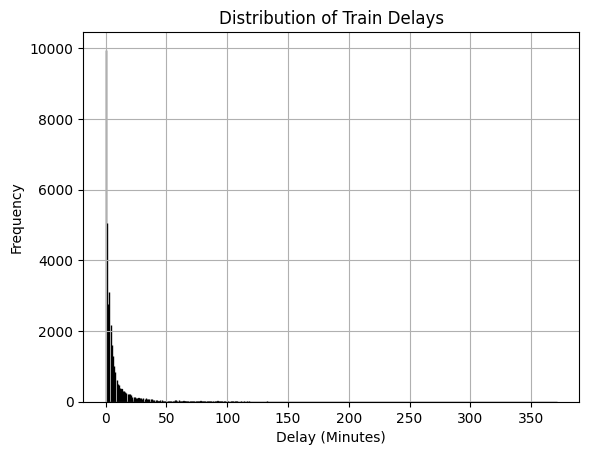

In [152]:
# We start by analyzing the frequency of train delays
performance_df['Delay'].hist(bins=10000, edgecolor='black')
plt.title('Distribution of Train Delays')
plt.xlabel('Delay (Minutes)')
plt.ylabel('Frequency')
plt.show()

We see from our distribution that delay times follow a logarithmic function. We look to transform the data in order for our models to better fit. Because there is a significant amount of data points with a delay of zero, we use the function log1p to help shape our data.

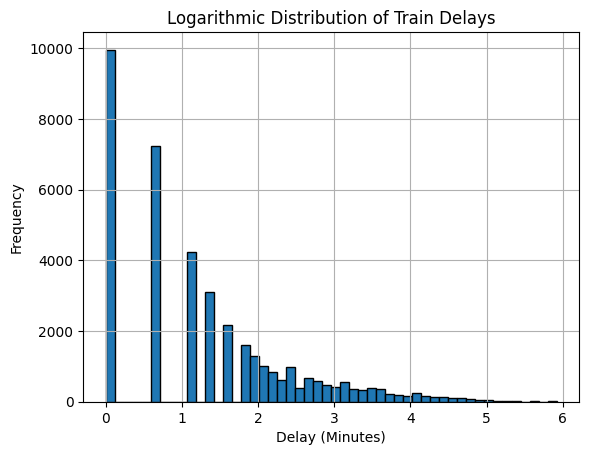

In [176]:
# Convert delay data to logarithmic scaling
performance_df['Log_Delay'] = np.log1p(performance_df['Delay'])

performance_df['Log_Delay'].hist(bins=50, edgecolor='black')
plt.title('Logarithmic Distribution of Train Delays')
plt.xlabel('Delay (Minutes)')
plt.ylabel('Frequency')
plt.show()

<ipython-input-155-40045dd539b7>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  performance_df['Hour'] = pd.to_datetime(performance_df['Sch Dp Time']).dt.hour


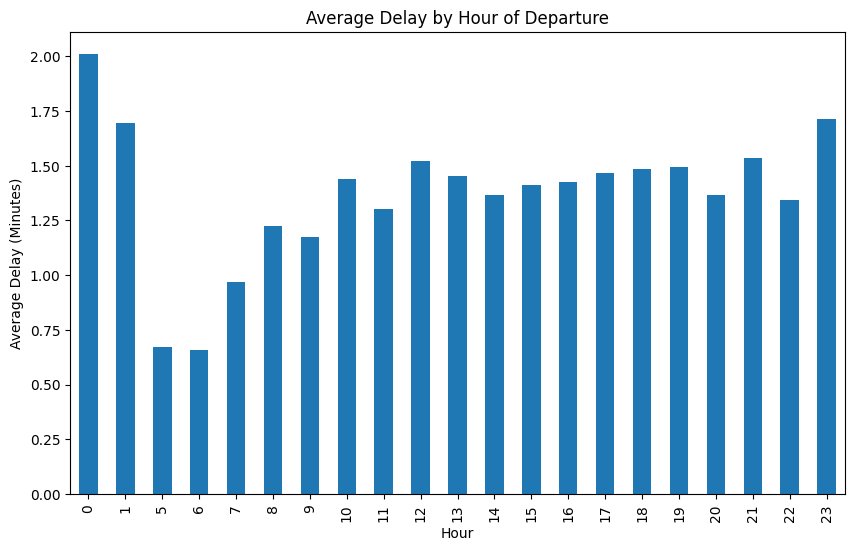

In [155]:
# We look to see if there is any correlation between the hour od departure and delay
performance_df['Hour'] = pd.to_datetime(performance_df['Sch Dp Time']).dt.hour
performance_df.groupby('Hour')['Log_Delay'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average Delay by Hour of Departure')
plt.xlabel('Hour')
plt.ylabel('Average Delay (Minutes)')
plt.show()

Measured in military time, we see that there is an increase in delays as the day persists. The inconsistency between such pattern, hours 0 and 1, can be explained by the standard operating schedule of Amtrak (5AM-1AM).

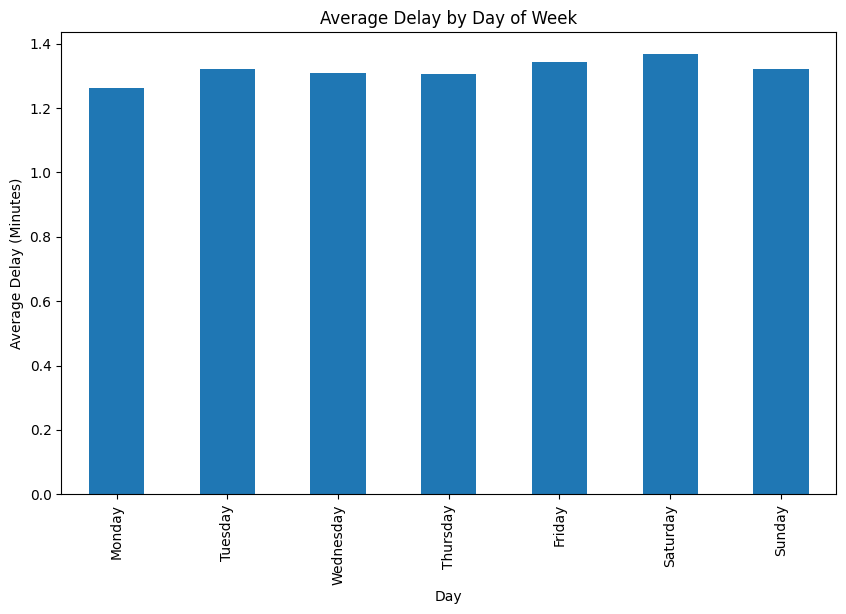

In [160]:
# We look to see if there is a correlation between day of the week and delay times
ax = performance_df.groupby('Day of Week')['Log_Delay'].mean().plot(kind='bar', figsize=(10, 6))
plt.title('Average Delay by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average Delay (Minutes)')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

We see there is little variation between average delay times and day of the week.

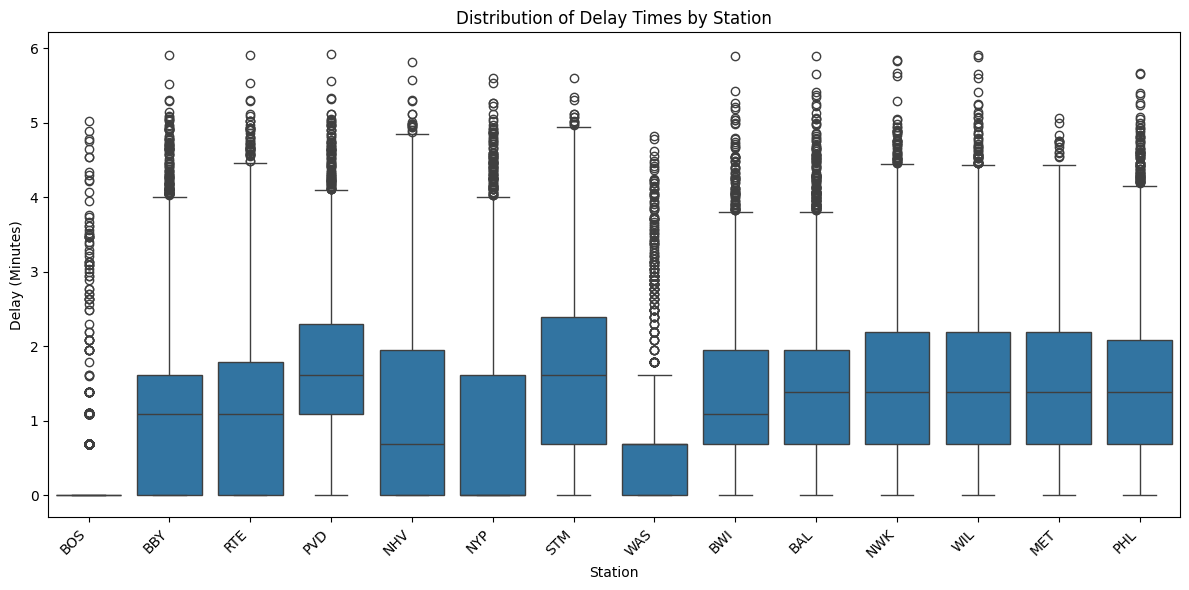

In [159]:
# We look now at delay time by station.
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.boxplot(x='Station', y='Log_Delay', data=performance_df)
plt.title('Distribution of Delay Times by Station')
plt.xlabel('Station')
plt.ylabel('Delay (Minutes)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

We see most stations exhibit similar distributions except BOS (Boston) and WAS (Washington DC). This may be explained by both stations being end points between the Acela route, specifically Boston.

#MERGE DATASET

In [164]:
# MERGING DATASETS
# We start by renaming performance_df's date column to match weather_df.

# Given the granularity of performance_df, we must average and total daily delays
# in order for the datasets to be compatible. We also add the total amount of
# service disruptions and cancellations to possibly explain high delay times.

# We finally merge the datasets on "DATE" and "Station" as our primary keys
performance_df.rename(columns={'Sch Dp Date':'DATE'}, inplace=True)
performance_daily = performance_df.groupby(['DATE', 'Station', 'Day of Week']).agg(
    total_delay=('Delay', 'sum'),          # Total delay for the day
    average_delay=('Delay', 'mean'),      # Average delay for the day
    total_disruptions=('Service Disruption', 'sum'),  # Total service disruptions
    total_cancellations=('Cancellations', 'sum')      # Total cancellations
).reset_index()
performance_daily['DATE'] = pd.to_datetime(performance_daily['DATE'])
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

merged_df = pd.merge(performance_daily, weather_df, on=['DATE', 'Station'], how='left')

merged_df.head()

,DATE,Station,Day of Week,total_delay,average_delay,total_disruptions,total_cancellations,AWND,PRCP,SNOW,...,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT06,WT08,WT09
0,2024-01-01,BAL,0,40.002,2.105368,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01,BBY,0,20.994,1.234941,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01,BOS,0,3.000,0.333333,0,0,6.26,0.0,0.0,...,320.0,12.1,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-01-01,BWI,0,22.998,1.437375,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01,MET,0,30.000,3.333333,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# Because the weather dataset only covers 4 select stations out of 14 (BOS, PHL, NYP, WAS),
# we have many null values. To fix this, given the proximity of regions between all stations,
# we average the daiy weather columns repsectively and input them into the missing columns.
# For binary values, we simply fill null values with 0.
numeric_weather_df = weather_df.select_dtypes(include=[np.number])
daily_weather_avg = numeric_weather_df.groupby(weather_df['DATE']).mean().reset_index()
for col in numeric_weather_df.columns:
    merged_df[col].fillna(merged_df['DATE'].map(daily_weather_avg.set_index('DATE')[col]), inplace=True)

<ipython-input-165-712b3d68d583>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna(merged_df['DATE'].map(daily_weather_avg.set_index('DATE')[col]), inplace=True)


MERGED DATASET

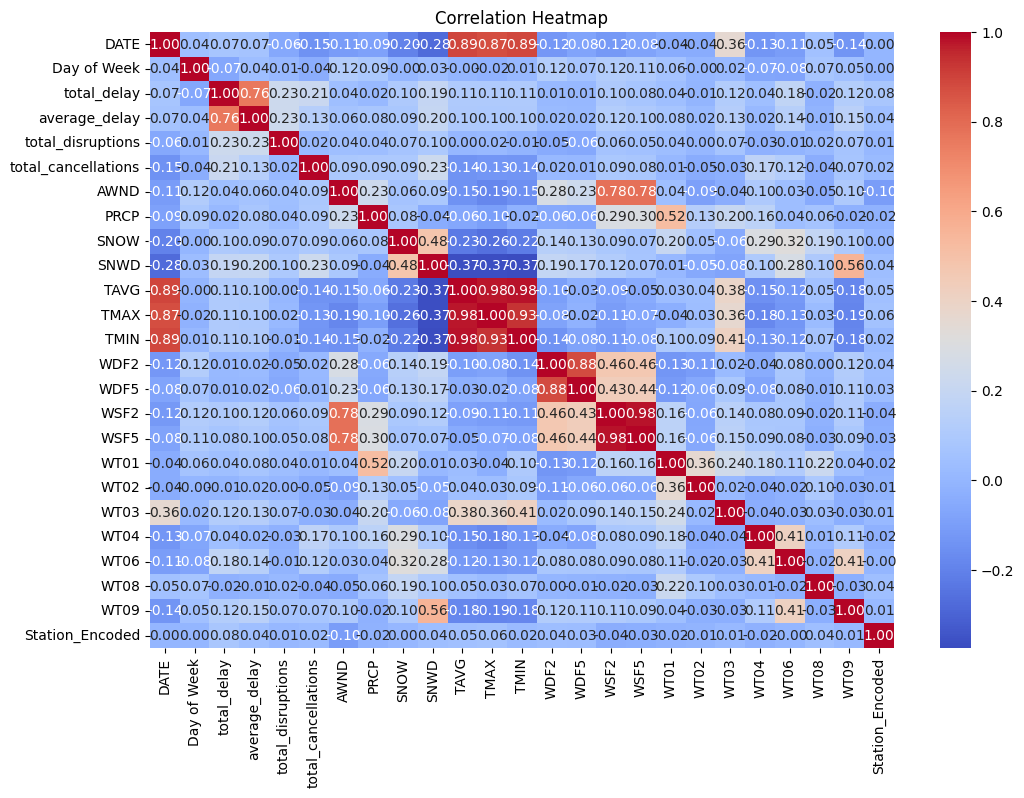

In [168]:
# We encode "Station" as a label such that it works in our heat map and model-making
# down the line.
le = LabelEncoder()
merged_df['Station_Encoded'] = le.fit_transform(merged_df['Station'])
merged_numeric = merged_df.drop(columns=['Station'])
correlation_matrix = merged_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

We see from following the rows of total_delay and average_delay in the heatmap matrix that weather variables have little correlation.

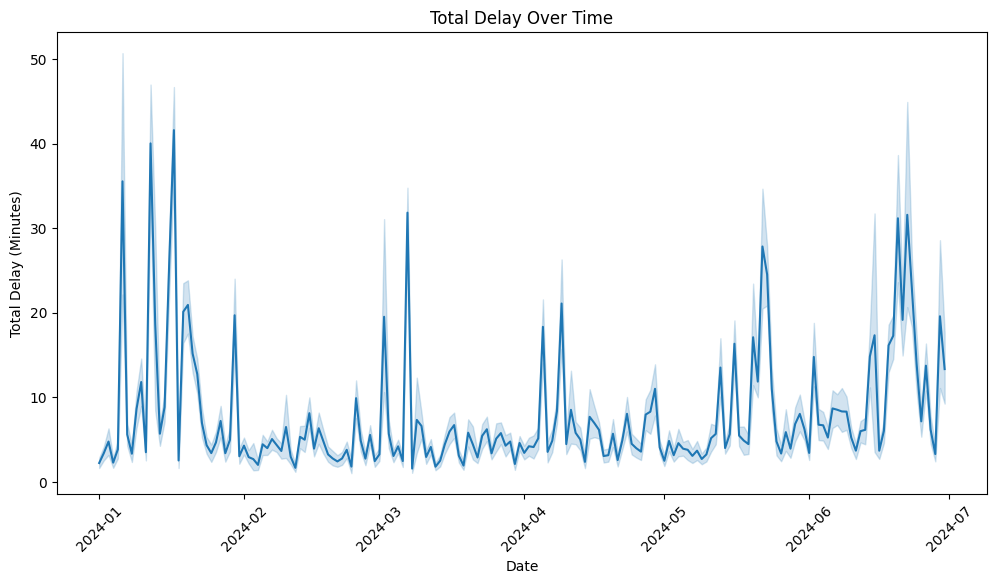

In [143]:
# We now look at the average delay time by date
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATE', y='average_delay', data=merged_df)
plt.title('Average Delay Over Time')
plt.xlabel('Date')
plt.ylabel('Average Delay (Minutes)')
plt.xticks(rotation=45)
plt.show()


We see spikes on certain days of increased delay times, possibly due to weather conditions, service disruptions, or cancellations.

#XGBoost

In [169]:
# We define our features for XGBoost to look at precipitation, min and max temps,
# air speed averages, snowfall, snow depth, and stations.
# These features are meant to predict average delay time.
features = ['PRCP', 'TMAX', 'TMIN', 'AWND', 'SNOW', 'SNWD', 'Station_Encoded']
X = merged_df[features]
y = merged_df['average_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# We decided to vary the number of estimators, max depth of the trees, and learning rate.
# For more specific parameters, we also vary the fraction of subsamples and columns samples.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# We initialize XGBoost and use GridSearch to find the best model.
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# We make and print our predictions
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END

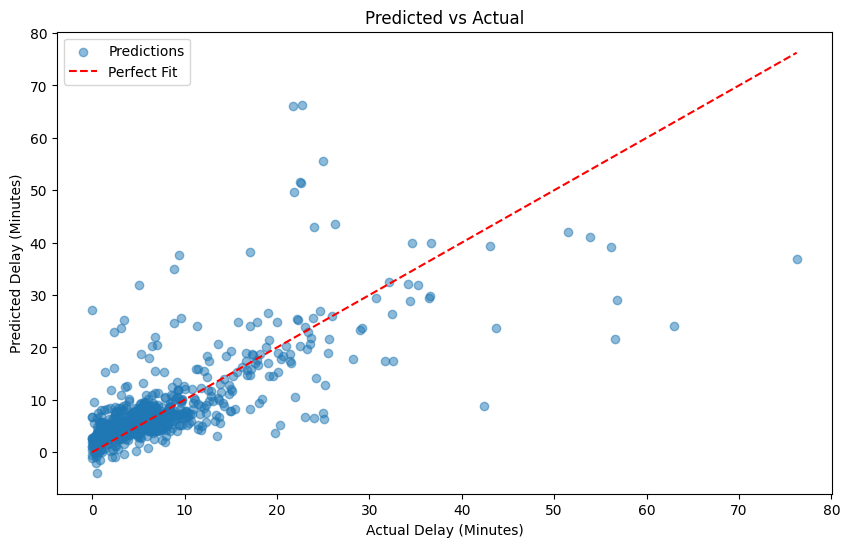

In [170]:
# We show the model's prediction to the actual values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.legend()
plt.show()

#RANDOM FORESTS - Merged

In [172]:
# We reinitialize X and y with the same features as XGBoost
features = ['PRCP', 'TMAX', 'TMIN', 'AWND', 'SNOW', 'SNWD', 'Station_Encoded']
X = merged_df[features]
y = merged_df['average_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# We set our parameters to adjust the number of estimators, the max depth of the tree,
# The minimum number of tree splits, and the minimum number of leaves
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# We find and fit the Random Forests model
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# We find our test predictions and evaluations for the model
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Mean Squared Error (MSE): 33.99286815053797
R^2 Score: 0.536046567430083
Cross-Validated MSE: 53.74421244063406 ± 12.935274521908365


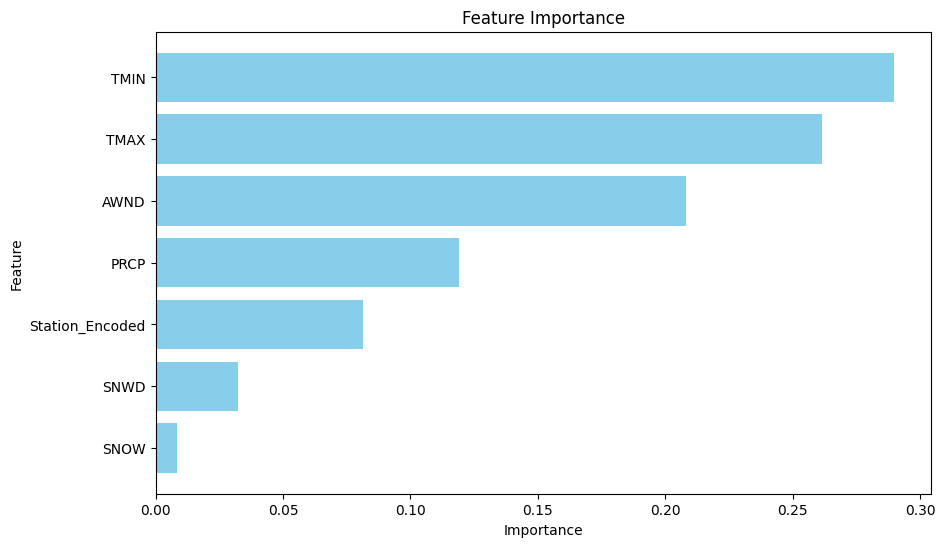

In [173]:
# We find the importance of features in a barchart
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

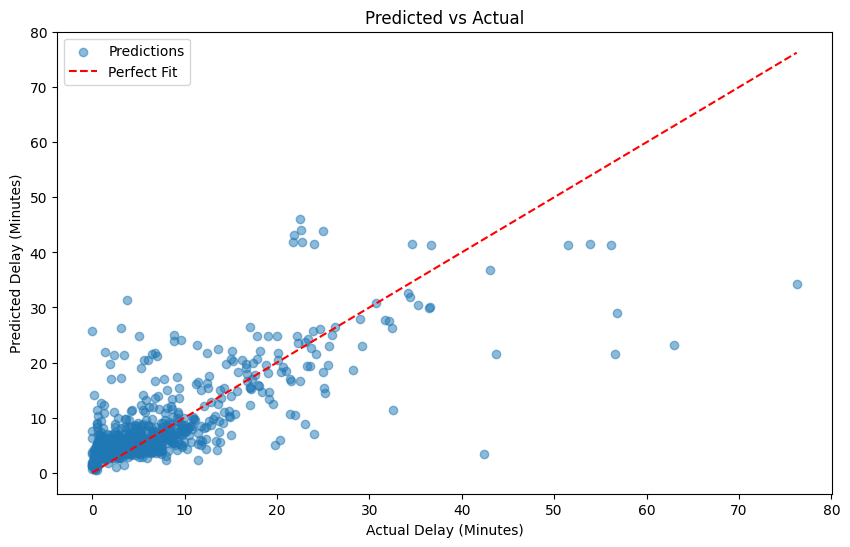

In [175]:
# We show the model's prediction to the actual values for Random Forests
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.legend()
plt.show()